# Model Doğrulama / Model Tuning

In [47]:
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import model_selection
import matplotlib.pyplot as plt

In [48]:
hit = pd.read_csv("Hitters.csv")

df = hit.copy()

df = df.dropna()

dms = pd.get_dummies(df[["League", "Division", "NewLeague"]])

y = df["Salary"]

X_ = df.drop(["Salary", "League", "Division", "NewLeague"], axis = 1).astype("float64")

X = pd.concat([X_, dms[["League_N", "Division_W", "NewLeague_N"]]], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

training = df.copy()

pca = PCA()

X_reduced_train = pca.fit_transform(scale(X_train))

lm = LinearRegression()

pcr_model = lm.fit(X_reduced_train, y_train)

y_pred_train = pcr_model.predict(X_reduced_train)

pca2 = PCA()

X_reduced_test = pca2.fit_transform(scale(X_test))

y_pred_test = pcr_model.predict(X_reduced_test)

In [49]:
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))

405.15753641499646


In [50]:
pcr_model_col1 = lm.fit(X_reduced_train[:, 0:1], y_train)  # modelleme için birinci bileşeni al

y_pred_test_col1 = pcr_model_col1.predict(X_reduced_test[:, 0:1])  # boyutlar uyuşmalı!

# şu anda tek bileşenli bir regresyon modeli kurmuş olduk.

print(np.sqrt(mean_squared_error(y_test, y_pred_test_col1)))  

392.38935589493457


In [51]:
pcr_model_colms2 = lm.fit(X_reduced_train[:, 0:2], y_train)  # modelleme için ilk iki bileşeni al.

y_pred_test_colms2 = pcr_model_colms2.predict(X_reduced_test[:, 0:2])  # boyutlar uyuşmalı!

# şu anda iki bileşenli bir regresyon modeli kurmuş olduk.

print(np.sqrt(mean_squared_error(y_test, y_pred_test_colms2))) 

396.38761247967653


In [52]:
pcr_model_colms5 = lm.fit(X_reduced_train[:, 0:5], y_train)  # modelleme için ilk beş bileşeni al.

y_pred_test_colms5 = pcr_model_colms5.predict(X_reduced_test[:, 0:5])  # boyutlar uyuşmalı!

# şu anda beş bileşenli bir regresyon modeli kurmuş olduk.

print(np.sqrt(mean_squared_error(y_test, y_pred_test_colms5))) 

397.233644079134


In [53]:
pcr_model_colms10 = lm.fit(X_reduced_train[:, 0:10], y_train)  # modelleme için ilk on bileşeni al.

y_pred_test_colms10 = pcr_model_colms10.predict(X_reduced_test[:, 0:10])  # boyutlar uyuşmalı!

# şu anda on bileşenli bir regresyon modeli kurmuş olduk.

print(np.sqrt(mean_squared_error(y_test, y_pred_test_colms10))) 

390.79142556822234


In [54]:
# 10 katlı cross validation yapılandırması yapmak için;
# 'shuffle', grupların ayrılmadan önce karıştırılıp karıştırılmayacağı anlamına gelir. Bizim için 'True'.

cv_10 = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1)

In [55]:
lm1 = LinearRegression()

RMSE = []

In [56]:
for i in np.arange(1, X_reduced_train.shape[1] + 1):
    
    scoreSquare = model_selection.cross_val_score(lm1, X_reduced_train[:, :i], y_train.ravel(), cv = cv_10, 
                                                  scoring = "neg_mean_squared_error").mean()
    
    score = np.sqrt(-1 * scoreSquare)
    
    RMSE.append(score)

In [57]:
RMSE

[339.00500170955814,
 335.4728032081954,
 335.2590543755473,
 335.7884270015904,
 331.09740630173496,
 329.0340331060009,
 328.19368073916246,
 331.4554758418423,
 333.67757478496605,
 339.503303868483,
 340.5292981595513,
 344.5766545758867,
 351.26086167973125,
 356.4667660069188,
 357.2309164188571,
 342.7834361594297,
 343.74562772537456,
 344.75198625737386,
 353.3705052990855]

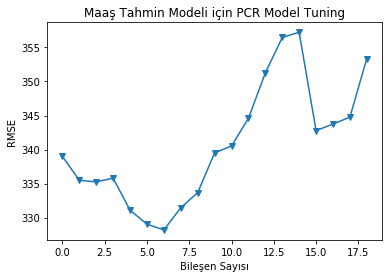

In [58]:
plt.plot(RMSE, "-v")
plt.xlabel("Bileşen Sayısı")
plt.ylabel("RMSE")
plt.title("Maaş Tahmin Modeli için PCR Model Tuning");

# bileşen sayısı arttıkça, bir süre boyunca RMSE'nin düştüğü görülmüş.
# bir süreden sonra ise artmaya başlamış.
# bileşen sayısı değişen sayısı kadar olduğunda çok da iyi bir performans elde edilmediğini görüyoruz.
# optimum bileşen sayısının kaç olması gerektiğini bulmuş oluyoruz. (Bizim için 6) - en düşük RMSE değeri

In [59]:
# model hiperparametresini, elimizdeki optimum bileşen değeri aracılığı ile oluşturmamız gerekiyor.
# yani şimdiki işimiz final modelini oluşturmak.

lm2 = LinearRegression()

In [60]:
# PCR eğitim modelinin kurulması(final)

pcr_model_final = lm2.fit(X_reduced_train[:, 0:6], y_train)

y_pred_train_final = pcr_model_final.predict(X_reduced_train[:, 0:6])

# tahmin edilen değer ile eğitim içerisindeki gerçek değerler için bulunan eğitim hatası.
print(np.sqrt(mean_squared_error(y_train, y_pred_train_final)))

308.82659830945016


In [61]:
# PCR test modelinin kurulması(final)

pcr_model_final = lm2.fit(X_reduced_train[:, 0:6], y_train)

y_pred_test_final = pcr_model_final.predict(X_reduced_test[:, 0:6])

# tahmin edilen değer ile eğitim içerisindeki gerçek değerler için bulunan eğitim hatası.
print(np.sqrt(mean_squared_error(y_test, y_pred_test_final)))

393.1198700096223


### burada modeli doğrulamak için cross validation yöntemleri uygulanmıştır.

### optimum oluşmaya çalıştığımız test hatamız.